In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
#from rep.estimators import TMVAClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, RandomForestClassifier
from sklearn.feature_selection import VarianceThreshold
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import roc_curve, roc_auc_score
#from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
import theano

Using gpu device 0: GeForce GTX 860M (CNMeM is enabled)


In [2]:
def compare_rocs(clf_dict, data_dict, 
                 loc_title = 'ROC comparison for electron data', 
                 color_dict=None,
                 size = (8,8)):
    keys = list(clf_dict.keys())
    results_dict = {}
    
    if not color_dict:
        colors = plt.cm.rainbow(np.linspace(0,1,len(keys)))
        color_dict = {}
        for key, color in zip(keys, colors):
            color_dict[key] = color 
            
    plt.figure(figsize=size)
    for key in keys:
        cur_results = dict.fromkeys(['ROC_curve', 'ROC_AUC'])
        cur_clf = clf_dict[key]
        print('Fitting {0:}.'.format(key))
        cur_clf.fit(data_dict['train'][features], data_dict['train_labels'])
        cur_probs = cur_clf.predict_proba(data_dict['test'][features])
        cur_auc = roc_auc_score(data_dict['test_labels'], cur_probs[:, 1])
        cur_results['ROC_AUC'] = cur_auc
        fpr, tpr, _ = roc_curve(data_dict['test_labels'], cur_probs[:, 1])
        cur_results['ROC_curve'] = fpr, tpr
        results_dict[key] = cur_results

        plt.plot(fpr, tpr, color=color_dict[key], label = key + " AUC = %.3f" % cur_results['ROC_AUC'])
    
    
    plt.title(loc_title)
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.legend(loc=4)
    plt.show()
    
    return results_dict

In [3]:
data_folder = 'data/MC12/TrainMixture/' + \
'TrainAllTks-EvalAllTks-NoReweight/GhostAccFrac1.0/TMVA-NoPreSels-NoGECs/Electron/Upstream/'

data_folder = 'data/MC12/TrainMixture/' + \
'test/GhostAccFrac1.0/TMVA-NoPreSels-NoGECs/Electron/Upstream/'

signal_file = 'data_train_signal.csv'
background_file = 'data_train_bkg.csv'
data_signal = pd.read_csv(data_folder + signal_file, index_col=0)
data_bkg = pd.read_csv(data_folder + background_file, index_col=0)
features = np.genfromtxt(data_folder + 'train_features.txt', dtype='str')

In [4]:
data_train_signal, data_test_signal = train_test_split(data_signal, test_size=0.3, random_state=42)
data_train_bkg, data_test_bkg = train_test_split(data_bkg, test_size=0.3, random_state=42)


train_data = pd.concat([data_train_signal, data_train_bkg], axis=0)
train_labels = np.concatenate((np.ones(len(data_train_signal)), np.zeros(len(data_train_bkg))), axis=0)

test_data = pd.concat([data_test_signal, data_test_bkg], axis=0)
test_labels = np.concatenate((np.ones(len(data_test_signal)), np.zeros(len(data_test_bkg))), axis=0)

sample_weight = np.concatenate((np.ones(len(data_train_signal)),
                                   1 * np.ones(len(data_train_bkg))), axis=0)

In [5]:
features = train_data[features].columns[(train_data[features].var(skipna=False) != 0)]

In [6]:
my_clfs = {}

xgb_params = {'base_score': 0.5,
 'colsample_bytree': 0.6,
 'gamma': 0,
 'learning_rate': 0.03,
 'max_depth': 3,
 'n_estimators': 800,
 'nthread': 8,
 'objective': 'binary:logistic',
 'seed': 0,
 'silent': True,
 'subsample': 0.5}

my_clfs['XGB'] = XGBClassifier(**xgb_params )

ada_params = {'algorithm': 'SAMME.R',
 'base_estimator': None,
 'learning_rate': 0.3,
 'n_estimators': 800,
 'random_state': 0}

my_clfs['AdaBoost'] = AdaBoostClassifier(**ada_params)

rf_params = {'class_weight': None,
 'criterion': 'gini',
 'max_depth': 15,
 'max_features': 0.5,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 800,
 'n_jobs': 8,
 'random_state': 0}

my_clfs['RF'] = RandomForestClassifier(**rf_params)
#my_clfs['Bagged XGB'] = BaggingClassifier(base_estimator=my_clfs['XGB'])

data_el = {}
data_el['train'] = train_data
data_el['train_labels'] = train_labels
data_el['test'] = test_data
data_el['test_labels'] = test_labels
data_el['features'] = features

Fitting XGB.
Fitting RF.
Fitting AdaBoost.


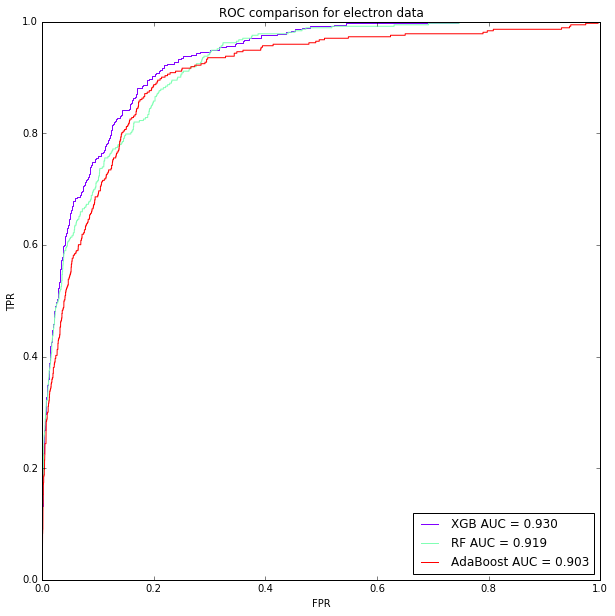

In [7]:
a = compare_rocs(my_clfs, data_el, size=(10,10))

In [74]:
np.random.seed(1337)  # for reproducibility

from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.optimizers import SGD, Adam, RMSprop
from keras.utils import np_utils
from sklearn.preprocessing import MinMaxScaler

batch_size = 64
nb_classes = 2
nb_epoch = 100
feats = data_el['features']
input_0 = len(feats)
units = 50
drop = 0.05
thres = 10000

MMS = MinMaxScaler()

# the data, shuffled and split between tran and test sets

X_train, y_train = MMS.fit_transform(data_el['train'][feats]), data_el['train_labels']
X_test, y_test = MMS.fit_transform(data_el['test'][feats]), data_el['test_labels'] 
data_el['features'] = features

# convert class vectors to binary class matrices
Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

model = Sequential()
model.add(Dense(units, input_shape=(input_0,)))
model.add(Activation('relu'))
model.add(Dropout(drop))
model.add(Dense(units))
model.add(Activation('relu'))
model.add(Dropout(drop))
model.add(Dense(units, init='he_normal', activation='tanh'))
#model.add(Activation('relu'))
model.add(Dropout(drop))
model.add(Dense(units))
model.add(Activation('relu'))
model.add(Dropout(drop))
model.add(Dense(nb_classes))
model.add(Activation('softmax'))

rms = RMSprop()
model.compile(loss='categorical_crossentropy', optimizer=rms)

model.fit(X_train, Y_train,
          batch_size=batch_size, nb_epoch=nb_epoch, shuffle = True,
          show_accuracy=True, verbose=4, validation_split = 0.20)
          #validation_data=(X_train[thres:], Y_train[thres:]))
#score = model.evaluate(X_test, Y_test,
#                       show_accuracy=True, verbose=0)
#print 'Test score:', score[0]
#print 'Test accuracy:', score[1]

Train on 11199 samples, validate on 2800 samples
Epoch 1/100
Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100
Epoch 22/100
Epoch 23/100
Epoch 24/100
Epoch 25/100
Epoch 26/100
Epoch 27/100
Epoch 28/100
Epoch 29/100
Epoch 30/100
Epoch 31/100
Epoch 32/100
Epoch 33/100
Epoch 34/100
Epoch 35/100
Epoch 36/100
Epoch 37/100
Epoch 38/100
Epoch 39/100
Epoch 40/100
Epoch 41/100
Epoch 42/100
Epoch 43/100
Epoch 44/100
Epoch 45/100
Epoch 46/100
Epoch 47/100
Epoch 48/100
Epoch 49/100
Epoch 50/100
Epoch 51/100
Epoch 52/100
Epoch 53/100
Epoch 54/100
Epoch 55/100
Epoch 56/100
Epoch 57/100
Epoch 58/100
Epoch 59/100
Epoch 60/100
Epoch 61/100
Epoch 62/100
Epoch 63/100
Epoch 64/100
Epoch 65/100
Epoch 66/100
Epoch 67/100
Epoch 68/100
Epoch 69/100
Epoch 70/100
Epoch 71/100
Epoch 72/100
Epoch 73/100
Epoch 74/10

6001/6001 [==============================] - 0s     


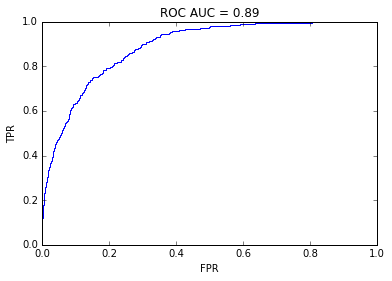

In [76]:
prob_bdt = model.predict_proba(X_test)

roc_auc = roc_auc_score(test_labels, prob_bdt[:, 1])
fpr, tpr, _ = roc_curve(test_labels, prob_bdt[:, 1])

plt.plot(fpr, tpr)
plt.title("ROC AUC = %.2f" % roc_auc)
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.show()